# LSTM_Exam Implementation 

In [35]:
import torch 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch.nn as nn 
from sklearn.metrics import accuracy_score, precision_score, recall_score


In [23]:
df = pd.read_csv('daily_csv.csv')
df = df.dropna()
prices = df['Price'].values
minn, maxx = prices.min(), prices.max()
prices = (prices - minn) / (maxx - minn)
X, y = [], []
sequence_length = 10
for i in range(5900):
    l = []
    for j in range(i, i + sequence_length):
        l.append(prices[j])
    X.append(l)
    y.append(prices[i + sequence_length])
X, y = np.array(X), np.array(y)

In [24]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size= 0.10, random_state= 42, stratify= None)

In [25]:
class Data(torch.utils.data.Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = torch.tensor(x, dtype= torch.float32)
        self.y = torch.tensor(y, dtype= torch.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [26]:
train = Data(xtrain, ytrain)
test = Data(xtest, ytest)
train_loader = torch.utils.data.DataLoader(train, batch_size= 256, shuffle= True, drop_last= True)
test_loader = torch.utils.data.DataLoader(test, batch_size= 256, drop_last= True)

### LSTM Model ###

In [27]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, 
                            dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # get the last time step
        out = self.fc(out)
        return out

In [28]:
model = Network()
model = model.to('cpu')
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001, weight_decay= 0.0001)

In [ ]:
def l1_l2_regularization(model, l1_lambda=1e-5, l2_lambda=1e-4):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    l2_norm = sum((p ** 2).sum() for p in model.parameters())
    return l1_lambda * l1_norm + l2_lambda * l2_norm

# ----- Early Stopping Setup -----
best_val_loss = float('inf')
patience = 100
patience_counter = 0
best_model_state = None

# ----- Training Loop -----
for epoch in range(1500):
    model.train()
    running_loss = 0.0
    for input, target in train_loader:
        optimizer.zero_grad()
        input, target = input.reshape((-1, sequence_length, 1)), target
        output = model(input).reshape(-1)
        loss = criterion(output, target)
        loss += l1_l2_regularization(model)  # Add L1/L2 penalty
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # ----- Validation Step (with metrics) ----
    model.eval()
val_loss = 0.0
all_preds = []
all_targets = []

with torch.no_grad():
    for val_input, val_target in val_loader:
        val_input, val_target = val_input.reshape((-1, sequence_length, 1)), val_target
        val_output = model(val_input).reshape(-1)
        
        # Use sigmoid if output is raw logits (no activation in model)
        val_probs = torch.sigmoid(val_output)
        val_preds = (val_probs > 0.5).int()  # Threshold at 0.5
        
        all_preds.extend(val_preds.tolist())
        all_targets.extend(val_target.int().tolist())
        
        v_loss = criterion(val_output, val_target.float())
        val_loss += v_loss.item()

# ----- Compute Metrics -----
accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, zero_division=0)
recall = recall_score(all_targets, all_preds, zero_division=0)

if epoch % 50 == 0:
    print(f"Epoch {epoch} | Train Loss: {running_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"→ Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

    
    # ----- Early Stopping -----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    if epoch % 50 == 0:
        print(f"Epoch {epoch} | Train Loss: {running_loss:.4f} | Val Loss: {val_loss:.4f}")

# ----- Load Best Model -----
if best_model_state is not None:
    model.load_state_dict(best_model_state)


Epoch 0 | Train Loss: 18.5808 | Val Loss: 4.2939
Epoch 50 | Train Loss: 17.1925 | Val Loss: 4.3270
Epoch 100 | Train Loss: 16.8783 | Val Loss: 4.2751
Epoch 150 | Train Loss: 16.5075 | Val Loss: 4.2032
Epoch 200 | Train Loss: 14.5970 | Val Loss: 4.5192
Early stopping triggered at epoch 234


In [36]:
model.eval()
all_pred, all_label = [], []
with torch.no_grad():
    for input, target in test_loader:
        input, target = input.reshape((-1, sequence_length, 1)).to('cpu'), target.to('cpu')
        output = model(input).reshape(-1)
        all_pred.extend(output.to('cpu').detach().numpy())
        all_label.extend(target.to('cpu').detach().numpy())

In [37]:
print(mean_squared_error(all_pred, all_label))

0.05574455110680054


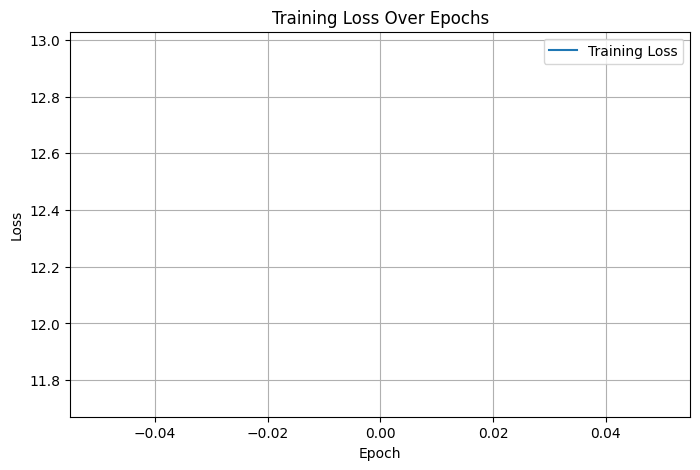

In [38]:
# Plot 1: Training Loss
plt.figure(figsize=(8, 5))
plt.plot(running_loss, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


### Number of Parameters ###

In [39]:
lstm = torch.nn.LSTM(input_size=1, hidden_size=5, batch_first=True)
params = sum(p.numel() for p in lstm.parameters() if p.requires_grad)
print(f"LSTM Parameters: {params}")


LSTM Parameters: 160
